In [34]:
#Cell 1: Install Dependencies
!pip install pandas numpy faker geopandas shapely tensorflow scikit-learn

In [43]:
#Cell 2: Generate Synthetic User Interaction Data
import numpy as np
import pandas as pd
from faker import Faker

# Initialize Faker and random seed
fake = Faker()
np.random.seed(42)

# Generate synthetic normal and anomalous session data
num_sessions = 5000
normal_sessions = 4000
anomalous_sessions = num_sessions - normal_sessions

data = []

# Normal sessions
for _ in range(normal_sessions):
    data.append({
        'booking_freq': np.random.poisson(2),
        'session_duration_sec': np.random.uniform(300, 1800),
        'device_consistency': 1,
        'user_latitude': np.random.uniform(30.10, 30.50),
        'user_longitude': np.random.uniform(-97.90, -97.60),
        'anomaly': 0
    })

# Anomalous sessions labeled as 1
for _ in range(anomalous_sessions):
    data.append({
        'booking_freq': np.random.uniform(20, 100),
        'session_duration_sec': np.random.choice([30, 10000]),
        'device_consistency': 0,
        'user_latitude': np.random.uniform(29.0, 31.0),
        'user_longitude': np.random.uniform(-99.0, -96.0),
        'anomaly': 1
    })

synthetic_df = pd.DataFrame(data).sample(frac=1).reset_index(drop=True)
synthetic_df.head()



,booking_freq,session_duration_sec,device_consistency,user_latitude,user_longitude,anomaly
0,0.0,562.322156,1,30.442295,-97.831846,0
1,2.0,1224.336377,1,30.271490,-97.845299,0
2,0.0,584.544547,1,30.235142,-97.876639,0
3,1.0,410.245121,1,30.167903,-97.744068,0
4,1.0,682.322935,1,30.425451,-97.714421,0


In [51]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=synthetic_df)

https://docs.google.com/spreadsheets/d/15uI_slandENsHWBCIspv1GCHGnyiA3SGmB_fPj42YS4/edit#gid=0


In [44]:
#Cell 3: Upload and Extract GTFS Data https://data.texas.gov/dataset/CapMetro-GTFS/r4v4-vz24/about_data
from google.colab import files
import zipfile
import os

# Upload GTFS Zip file
uploaded = files.upload()

# Extract GTFS Data
gtfs_zip_filename = list(uploaded.keys())[0]

with zipfile.ZipFile(gtfs_zip_filename, 'r') as zip_ref:
    zip_ref.extractall('capmetro_gtfs')

# List files
os.listdir('capmetro_gtfs')


Saving capmetro.zip to capmetro (5).zip


['Service_Area.prj',
 'Routes.cpg',
 'Stops.shp',
 'Transit_Hubs.dbf',
 'shapes.txt',
 'Service_Area.shp',
 'Transit_Hubs.prj',
 'stops.txt',
 'calendar_dates.txt',
 'routes.txt',
 'Routes.shx',
 'Service_Area.dbf',
 'feed_info.txt',
 'Transit_Hubs.shp',
 'fare_rules.txt',
 'transfers.txt',
 'Stops.prj',
 'Service_Area.cpg',
 'stop_times.txt',
 'fare_attributes.txt',
 'Routes.dbf',
 'Stops.dbf',
 'trips.txt',
 'Routes.shp',
 'Routes.prj',
 'Transit_Hubs.cpg',
 'Stops.shx',
 'Stops.cpg',
 'agency.txt',
 'Service_Area.shx',
 'Transit_Hubs.shx']

In [45]:
#Cell 4: Load and Process GTFS Stops
import geopandas as gpd

stops_df = pd.read_csv('capmetro_gtfs/stops.txt')
stops_gdf = gpd.GeoDataFrame(
    stops_df,
    geometry=gpd.points_from_xy(stops_df.stop_lon, stops_df.stop_lat),
    crs="EPSG:4326"
).to_crs("EPSG:3857")



In [46]:
#Cell 5: Calculate Geo-distance
import geopandas as gpd

synthetic_gdf = gpd.GeoDataFrame(
    synthetic_df,
    geometry=gpd.points_from_xy(synthetic_df.user_longitude, synthetic_df.user_latitude),
    crs="EPSG:4326"
).to_crs("EPSG:3857")

# Nearest distance calculation
def nearest_stop_distance(user_point, stops_gdf):
    distances = stops_gdf.distance(user_point)
    return distances.min() / 1000  # km conversion

synthetic_gdf['geo_distance_km'] = synthetic_gdf.geometry.apply(
    lambda x: nearest_stop_distance(x, stops_gdf)
)

synthetic_gdf = synthetic_gdf.drop(columns='geometry')
synthetic_gdf.head()


,booking_freq,session_duration_sec,device_consistency,user_latitude,user_longitude,anomaly,geo_distance_km
0,0.0,562.322156,1,30.442295,-97.831846,0,3.182542
1,2.0,1224.336377,1,30.271490,-97.845299,0,4.141147
2,0.0,584.544547,1,30.235142,-97.876639,0,0.040429
3,1.0,410.245121,1,30.167903,-97.744068,0,0.385016
4,1.0,682.322935,1,30.425451,-97.714421,0,0.165489


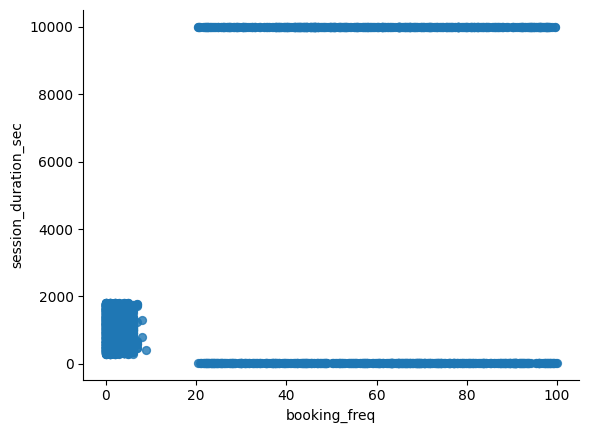

In [53]:
# @title booking_freq vs session_duration_sec

from matplotlib import pyplot as plt
synthetic_gdf.plot(kind='scatter', x='booking_freq', y='session_duration_sec', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

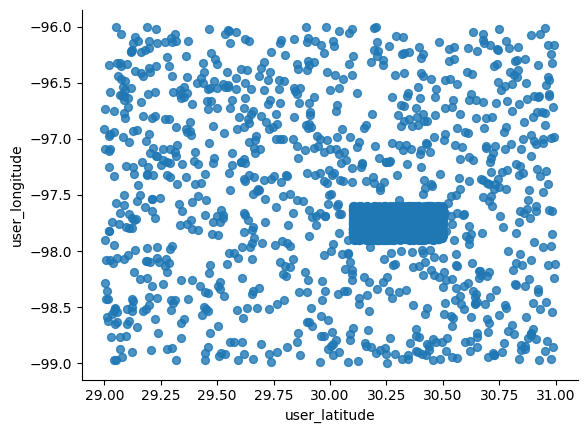

In [52]:
# @title user_latitude vs user_longitude

from matplotlib import pyplot as plt
synthetic_gdf.plot(kind='scatter', x='user_latitude', y='user_longitude', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [47]:
#cell 6: Build Autoencoder Model & Risk Scoring Engine
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Prepare data
features = synthetic_gdf[['booking_freq', 'session_duration_sec',
                          'device_consistency', 'geo_distance_km']]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(features)

# Split data
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

# Autoencoder architecture
input_dim = X_scaled.shape[1]
input_layer = Input(shape=(input_dim,))
encoder = Dense(16, activation="relu")(input_layer)
encoder = Dense(8, activation="relu")(encoder)
decoder = Dense(16, activation='relu')(encoder)
decoded = Dense(input_dim, activation='sigmoid')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_split=0.1)


Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1847 - val_loss: 0.0912
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0620 - val_loss: 0.0210
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0147 - val_loss: 0.0111
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0091 - val_loss: 0.0077
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0063 - val_loss: 0.0054
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0045 - val_loss: 0.0033
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030 - val_loss: 0.0024
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 10/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.3127e-04 - val_loss: 6.5826e-04
Epoch 11/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.3103e-04 - val_loss: 4.1889e-04
Epoch 12/50
113/113 ━━━━━━━━━━━━━━━━

In [48]:
#ell 7 Calculate Risk Scores (0-1)
# Get reconstruction error (risk scores)
reconstruction = autoencoder.predict(X_test)
reconstruction_error = np.mean(np.square(X_test - reconstruction), axis=1)

# Normalize errors between 0-1 (Risk scores)
risk_scores = (reconstruction_error - reconstruction_error.min()) / (reconstruction_error.max() - reconstruction_error.min())

# Add risk scores to dataset
results_df = pd.DataFrame(X_test, columns=['booking_freq', 'session_duration_sec', 'device_consistency', 'geo_distance_km'])
results_df['risk_score'] = risk_scores

results_df.head()


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


,booking_freq,session_duration_sec,device_consistency,geo_distance_km,risk_score
0,0.020009,0.140204,1.0,0.001712,0.008492
1,0.020009,0.157490,1.0,0.040673,0.089934
2,0.612950,1.000000,0.0,0.240146,0.014759
3,0.375795,1.000000,0.0,0.699760,0.027536
4,0.020009,0.083296,1.0,0.001750,0.009713


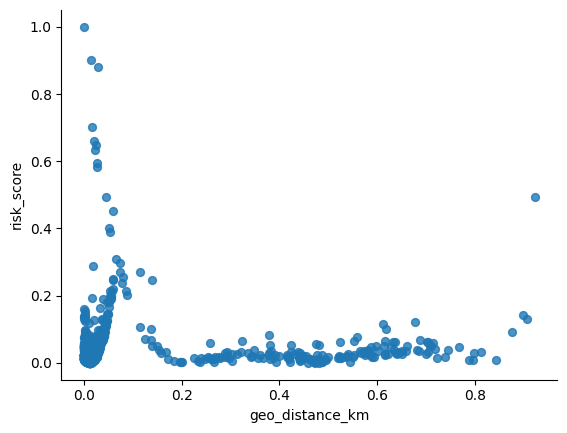

In [54]:
# @title geo_distance_km vs risk_score

from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='geo_distance_km', y='risk_score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [60]:
#Cell 8: Set Anomaly Threshold and Label Anomalies
# Set anomaly threshold (e.g., 95th percentile)
threshold = np.percentile(risk_scores, 95)

results_df['anomaly'] = results_df['risk_score'].apply(lambda x: 1 if x >= threshold else 0)

print(f"Anomaly threshold (95%): {threshold:.2f}")
# Display the entire results DataFrame (Risk scores, anomalies)
print("Full Results:\n")
print(results_df)

# Display the count of anomalies detected
print(f"\nTotal anomalies detected: {results_df['anomaly'].sum()} out of {len(results_df)} sessions.\n")

# Display only the detected anomalies for further analysis
print("\nDetected Anomalies:\n")
results_df[results_df['anomaly'] == 1]

Anomaly threshold (95%): 0.13
Full Results:

     booking_freq  session_duration_sec  device_consistency  geo_distance_km  \
0        0.020009              0.140204                 1.0         0.001712   
1        0.020009              0.157490                 1.0         0.040673   
2        0.612950              1.000000                 0.0         0.240146   
3        0.375795              1.000000                 0.0         0.699760   
4        0.020009              0.083296                 1.0         0.001750   
..            ...                   ...                 ...              ...   
995      0.020009              0.122966                 1.0         0.021020   
996      0.010005              0.175357                 1.0         0.034414   
997      0.020009              0.060814                 1.0         0.014880   
998      0.010005              0.072855                 1.0         0.003674   
999      0.000000              0.147826                 1.0         0.00820

,booking_freq,session_duration_sec,device_consistency,geo_distance_km,risk_score,anomaly
9,0.814479,0.000000,0.0,0.044906,0.492387,1
34,0.938775,0.000000,0.0,0.079611,0.255215,1
47,0.060028,0.038960,1.0,0.002319,0.153921,1
107,0.909243,0.000000,0.0,0.086906,0.215091,1
165,0.010005,0.134086,1.0,0.046975,0.144761,1
197,0.000000,0.070788,1.0,0.053107,0.212238,1
207,0.010005,0.058187,1.0,0.048906,0.144785,1
216,0.020009,0.116577,1.0,0.052031,0.167028,1
221,0.010005,0.034235,1.0,0.058360,0.212169,1
233,0.981172,1.000000,0.0,0.114708,0.270521,1


from matplotlib import pyplot as plt
_df_20['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_21['booking_freq'].plot(kind='hist', bins=20, title='booking_freq')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_22['session_duration_sec'].plot(kind='hist', bins=20, title='session_duration_sec')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_23['device_consistency'].plot(kind='hist', bins=20, title='device_consistency')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_24.plot(kind='scatter', x='index', y='booking_freq', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_25.plot(kind='scatter', x='booking_freq', y='session_duration_sec', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_26.plot(kind='scatter', x='session_duration_sec', y='device_consistency', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_27.plot(kind='scatter', x='device_consistency', y='geo_distance_km', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['booking_freq']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_28.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('booking_freq')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['session_duration_sec']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_29.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('session_duration_sec')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['device_consistency']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_30.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('device_consistency')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['geo_distance_km']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_31.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('geo_distance_km')

from matplotlib import pyplot as plt
_df_32['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_33['booking_freq'].plot(kind='line', figsize=(8, 4), title='booking_freq')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_34['session_duration_sec'].plot(kind='line', figsize=(8, 4), title='session_duration_sec')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_35['device_consistency'].plot(kind='line', figsize=(8, 4), title='device_consistency')
plt.gca().spines[['top', 'right']].set_visible(False)

Anomaly threshold (95%): 0.13
Full Results:
     booking_freq  session_duration_sec  device_consistency  geo_distance_km  \
0        0.020009              0.140204                 1.0         0.001712   
1        0.020009              0.157490                 1.0         0.040673   
2        0.612950              1.000000                 0.0         0.240146   
3        0.375795              1.000000                 0.0         0.699760   
4        0.020009              0.083296                 1.0         0.001750   
..            ...                   ...                 ...              ...   
995      0.020009              0.122966                 1.0         0.021020   
996      0.010005              0.175357                 1.0         0.034414   
997      0.020009              0.060814                 1.0         0.014880   
998      0.010005              0.072855                 1.0         0.003674   
999      0.000000              0.147826                 1.0         0.008200

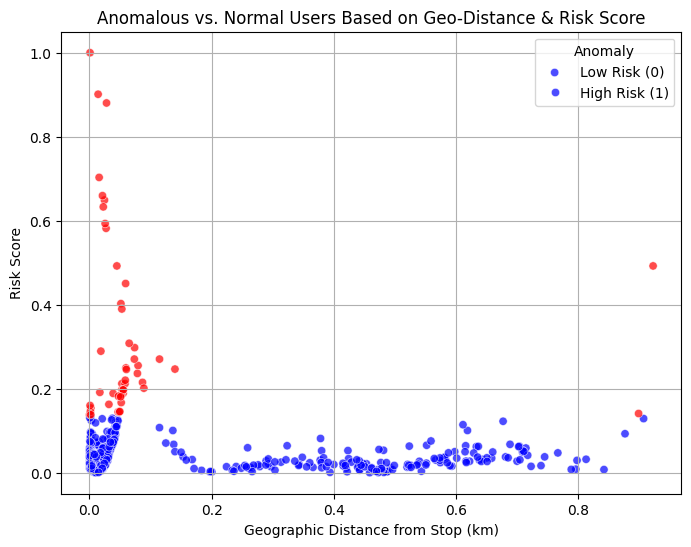

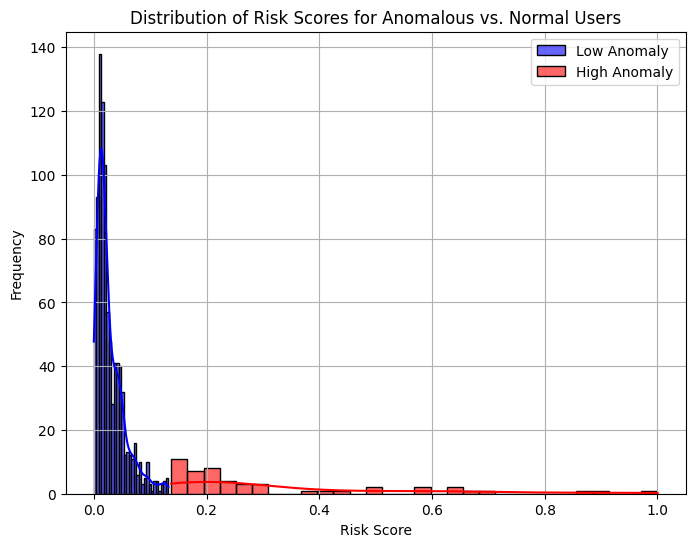

In [62]:
# Install necessary libraries
!pip install pandas numpy matplotlib seaborn

# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming results_df is already defined from anomaly detection process
# Set anomaly threshold (e.g., 95th percentile)
threshold = np.percentile(results_df['risk_score'], 95)
results_df['anomaly'] = results_df['risk_score'].apply(lambda x: 1 if x >= threshold else 0)

print(f"Anomaly threshold (95%): {threshold:.2f}")
print("Full Results:")
print(results_df)
print(f"\nTotal anomalies detected: {results_df['anomaly'].sum()} out of {len(results_df)} sessions.\n")

# Scatter Plot: Anomalies vs. Normal Users
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=results_df['geo_distance_km'],
    y=results_df['risk_score'],
    hue=results_df['anomaly'],
    palette={0: 'blue', 1: 'red'},
    alpha=0.7
)
plt.xlabel("Geographic Distance from Stop (km)")
plt.ylabel("Risk Score")
plt.title("Anomalous vs. Normal Users Based on Geo-Distance & Risk Score")
plt.legend(title="Anomaly", labels=["Low Risk (0)", "High Risk (1)"])
plt.grid(True)
plt.show()

# Histogram of Risk Scores for Normal and Anomalous Users
plt.figure(figsize=(8, 6))
sns.histplot(results_df[results_df['anomaly'] == 0]['risk_score'], bins=30, color='blue', label="Low Anomaly", kde=True, alpha=0.6)
sns.histplot(results_df[results_df['anomaly'] == 1]['risk_score'], bins=30, color='red', label="High Anomaly", kde=True, alpha=0.6)
plt.xlabel("Risk Score")
plt.ylabel("Frequency")
plt.title("Distribution of Risk Scores for Anomalous vs. Normal Users")
plt.legend()
plt.grid(True)
plt.show()
